In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
# from tensorboardX import SummaryWriter
# import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

In [3]:
seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)
torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [4]:
import torch
import torch.nn as nn

input_size = 10000
feature_size = 100
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches|
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
epoch = 50
LR = 0.001

cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

# initialize w_i(t=0) = 1 for task i
num_task = 2
Weight_loss_1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weight_loss_2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
params = [Weight_loss_1, Weight_loss_2]

MTL = MTLnet()
loss_func = nn.MSELoss()
L1_loss = nn.L1Loss()
optimizer1 = torch.optim.Adam(MTL.parameters(), lr=LR)
optimizer2 = torch.optim.Adam(params, lr=LR)

# pick alpha > 0 and pick the weights W
alpha = 0.16

for iter in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size/ mb_size) # input_size / mini-batch size
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, 100)

    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2 = minibatch

        Yhat1, Yhat2 = MTL(XE)
        loss1 = params[0]*loss_func(Yhat1, YE1.view(-1, 1))
        loss2 = params[1]*loss_func(Yhat2, YE2.view(-1, 1))
        # get the total loss
        sum_loss = torch.add(loss1, loss2)
        
        # initialize the initial loss when t = 0
        if iter == 0:
            initial_loss1 = loss1.data
            initial_loss2 = loss2.data

        # clear the gradients
        optimizer1.zero_grad()

        # do the backward pass to compute gradients for the whole set of weights
        sum_loss.backward(retain_graph=True)
        
        # compute G_i_W(t) and r_i(t) for task i
        # G_i_W(t) = L2-norm of the gradient of the weighted single-task loss w_i(t)*L_i(t)
        param = list(MTL.parameters())
        G_1R = torch.autograd.grad(loss1, param[0], retain_graph=True, create_graph=True)
        # print('sum of gradients=')
        # print(G_1R)
        # print(len(G_1R), len(G_1R[0]), len(G_1R[0][0]))
        G_1 = torch.norm(G_1R[0], 2)
        G_2R = torch.autograd.grad(loss2, param[0], retain_graph=True, create_graph=True)
        G_2 = torch.norm(G_2R[0], 2)
        # compute average G_W(t)
        G_avg = torch.div(torch.add(G_1, G_2), 2)

        # calculate the relative inverse training rate of task i, r_i(t)
        loss_ratio_1 = torch.div(loss1, initial_loss1)
        loss_ratio_2 = torch.div(loss2, initial_loss2)
        Avg_loss_ratio = torch.div(torch.add(loss_ratio_1, loss_ratio_2), 2)

        inverse_train_rate_1 = torch.div(loss_ratio_1, Avg_loss_ratio)
        inverse_train_rate_2 = torch.div(loss_ratio_2, Avg_loss_ratio)
        
        # compute L_grad
        # https://daesoolee.tistory.com/133, detach 무엇인가?
        constant_target_1 = G_avg*inverse_train_rate_1**alpha
        constant_target_2 = G_avg*inverse_train_rate_2**alpha
        constant_target_1.detach()
        constant_target_2.detach()

        optimizer2.zero_grad()
        # calculate gradient loss
        L_grad = torch.add(L1_loss(G_1, constant_target_1), L1_loss(G_2, constant_target_2))
        L_grad.backward()

        # update loss weights
        optimizer2.step()

        # update model weights
        optimizer1.step()

        # re-normalize
        coef = 2/torch.add(Weight_loss_1, Weight_loss_2)
        params = [coef*Weight_loss_1, coef*Weight_loss_2]

        epoch_cost = epoch_cost + (sum_loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (loss1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (loss2 / num_minibatches)
    
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))

    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.add(l1D,l2D))
        print('Iter-{}; MTL loss: {:.4}'.format(iter, sum_loss.item()))
        #print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))


<ipython-input-5-2d4049782fc0>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Weight_loss_1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
<ipython-input-5-2d4049782fc0>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Weight_loss_2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iter-0; MTL loss: 1.344
Iter-1; MTL loss: 0.7012
Iter-2; MTL loss: 0.615
Iter-3; MTL loss: 0.5884
Iter-4; MTL loss: 0.4662
Iter-5; MTL loss: 0.5003
Iter-6; MTL loss: 0.464
Iter-7; MTL loss: 0.4089
Iter-8; MTL loss: 0.4232
Iter-9; MTL loss: 0.4598
Iter-10; MTL loss: 0.4021
Iter-11; MTL loss: 0.346
Iter-12; MTL loss: 0.4361
Iter-13; MTL loss: 0.4339
Iter-14; MTL loss: 0.3687
Iter-15; MTL loss: 0.3629
Iter-16; MTL loss: 0.3309
Iter-17; MTL loss: 0.3586
Iter-18; MTL loss: 0.2848
Iter-19; MTL loss: 0.3793
Iter-20; MTL loss: 0.3318
Iter-21; MTL loss: 0.3714
Iter-22; MTL loss: 0.3378
Iter-23; MTL loss: 0.3084
Iter-24; MTL loss: 0.3606
Iter-25; MTL loss: 0.2933
Iter-26; MTL loss: 0.3158
Iter-27; MTL loss: 0.3543
Iter-28; MTL loss: 0.3116
Iter-29; MTL loss: 0.303
Iter-30; MTL loss: 0.3617
Iter-31; MTL loss: 0.3392
Iter-32; MTL loss: 0.2654
Iter-33; MTL loss: 0.3128
Iter-34; MTL loss: 0.3459
Iter-35; MTL loss: 0.2584
Iter-36; MTL loss: 0.2649
Iter-37; MTL loss: 0.276
Iter-38; MTL loss: 0.2963
It

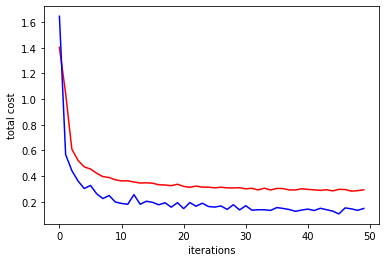

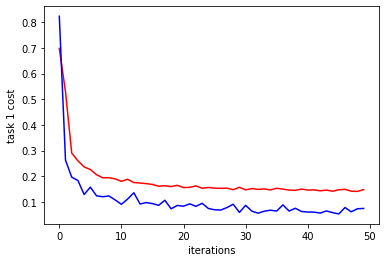

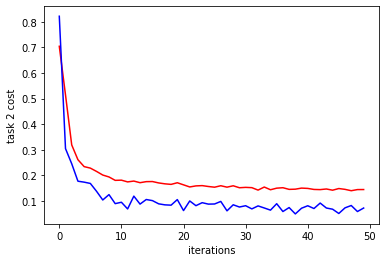

In [6]:
plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost1tr),'-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.show()

In [9]:
# without GradNorm

epoch = 50
LR = 0.001

cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

# initialize w_i(t=0) = 1 for task i
num_task = 2

MTL = MTLnet()
loss_func = nn.MSELoss()
L1_loss = nn.L1Loss()
optimizer1 = torch.optim.Adam(MTL.parameters(), lr=LR)


for iter in range(epoch):
    epoch_cost = 0
    coef = 0
    num_minibatches = int(input_size/ mb_size) # input_size / mini-batch size
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, 100)

    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2 = minibatch

        Yhat1, Yhat2 = MTL(XE)
        loss1 = loss_func(Yhat1, YE1.view(-1, 1))
        loss2 = loss_func(Yhat2, YE2.view(-1, 1))
        # get the total loss
        sum_loss = torch.add(loss1, loss2)

        # clear the gradients
        optimizer1.zero_grad()

        # do the backward pass to compute gradients for the whole set of weights
        sum_loss.backward(retain_graph=True)
        
        # update model weights
        optimizer1.step()


        epoch_cost = epoch_cost + (sum_loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (loss1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (loss2 / num_minibatches)
    
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))

    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.add(l1D,l2D))
        print('Iter-{}; MTL loss: {:.4}'.format(iter, sum_loss.item()))
        #print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))


Iter-0; MTL loss: 1.293
Iter-1; MTL loss: 0.649
Iter-2; MTL loss: 0.5152
Iter-3; MTL loss: 0.3609
Iter-4; MTL loss: 0.3391
Iter-5; MTL loss: 0.3539
Iter-6; MTL loss: 0.3968
Iter-7; MTL loss: 0.3739
Iter-8; MTL loss: 0.2815
Iter-9; MTL loss: 0.298
Iter-10; MTL loss: 0.2616
Iter-11; MTL loss: 0.2638
Iter-12; MTL loss: 0.34
Iter-13; MTL loss: 0.2428
Iter-14; MTL loss: 0.3078
Iter-15; MTL loss: 0.2587
Iter-16; MTL loss: 0.3069
Iter-17; MTL loss: 0.3115
Iter-18; MTL loss: 0.2405
Iter-19; MTL loss: 0.3037
Iter-20; MTL loss: 0.3379
Iter-21; MTL loss: 0.3174
Iter-22; MTL loss: 0.2188
Iter-23; MTL loss: 0.2359
Iter-24; MTL loss: 0.2954
Iter-25; MTL loss: 0.2422
Iter-26; MTL loss: 0.2966
Iter-27; MTL loss: 0.2423
Iter-28; MTL loss: 0.2352
Iter-29; MTL loss: 0.3728
Iter-30; MTL loss: 0.2935
Iter-31; MTL loss: 0.2178
Iter-32; MTL loss: 0.2783
Iter-33; MTL loss: 0.2614
Iter-34; MTL loss: 0.3232
Iter-35; MTL loss: 0.2363
Iter-36; MTL loss: 0.2437
Iter-37; MTL loss: 0.2448
Iter-38; MTL loss: 0.2605
I

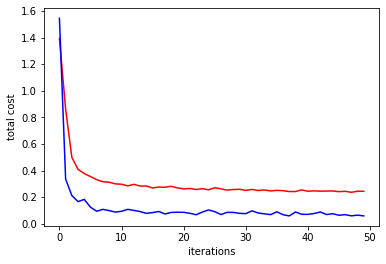

In [10]:
plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 



In [ ]:
print(params)

In [ ]:
param = list(MTL.parameters())
for p in param:
    print(p.shape)